<a href="https://colab.research.google.com/github/harshalk612/DATA6100/blob/main/NeuralNetworks/MNIST_example_with_second_half_blank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import jax.numpy as jnp
import jax
import time
from tqdm import tqdm

# What is this?

This notebook is based on the JAX training for MNIST and builds up a simple fully connected neural network (aka Multi-Layer-Perceptron MLP) starting from ordinary linear regression, and then logistic regression to build up the intuition for how it works.

#Load MNIST Dataset

In [5]:
import numpy as np
from torch.utils import data
from torchvision.datasets import MNIST

def numpy_collate(batch):
  if isinstance(batch[0], np.ndarray):
    return np.stack(batch)
  elif isinstance(batch[0], (tuple,list)):
    transposed = zip(*batch)
    return [numpy_collate(samples) for samples in transposed]
  else:
    return np.array(batch)

class NumpyLoader(data.DataLoader):
  def __init__(self, dataset, batch_size=1,
                shuffle=False, sampler=None,
                batch_sampler=None, num_workers=0,
                pin_memory=False, drop_last=False,
                timeout=0, worker_init_fn=None):
    super(self.__class__, self).__init__(dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        sampler=sampler,
        batch_sampler=batch_sampler,
        num_workers=num_workers,
        collate_fn=numpy_collate,
        pin_memory=pin_memory,
        drop_last=drop_last,
        timeout=timeout,
        worker_init_fn=worker_init_fn)

class FlattenAndCast(object):
  def __call__(self, pic):
    return np.ravel(np.array(pic, dtype=jnp.float32))

In [6]:
# Define our dataset, using torch datasets
mnist_dataset = MNIST('/tmp/mnist/', download=True, transform=FlattenAndCast())

batch_size = 128
training_generator = NumpyLoader(mnist_dataset, batch_size=batch_size, num_workers=0)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 33.1MB/s]


Extracting /tmp/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.30MB/s]


Extracting /tmp/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 7.92MB/s]


Extracting /tmp/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.83MB/s]


Extracting /tmp/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/mnist/MNIST/raw



## Train and test sets

In [7]:
# Get the full train dataset (for checking accuracy while training)
train_images = np.array(mnist_dataset.train_data).reshape(len(mnist_dataset.train_data), -1)
train_labels = np.array(mnist_dataset.train_labels)

N_train = 10000
train_images = train_images[0:N_train,:] #get a subset of the data
train_labels = train_labels[0:N_train]


# Get full test dataset
mnist_dataset_test = MNIST('/tmp/mnist/', download=True, train=False)
test_images = jnp.array(mnist_dataset_test.test_data.numpy().reshape(len(mnist_dataset_test.test_data), -1), dtype=jnp.float32)
test_labels = np.array(mnist_dataset_test.test_labels)


N_test = 10000
test_images = test_images[0:N_test,:] #get a subset of the data
test_labels = test_labels[0:N_test]

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


## Plotting examples of MNIST dataset

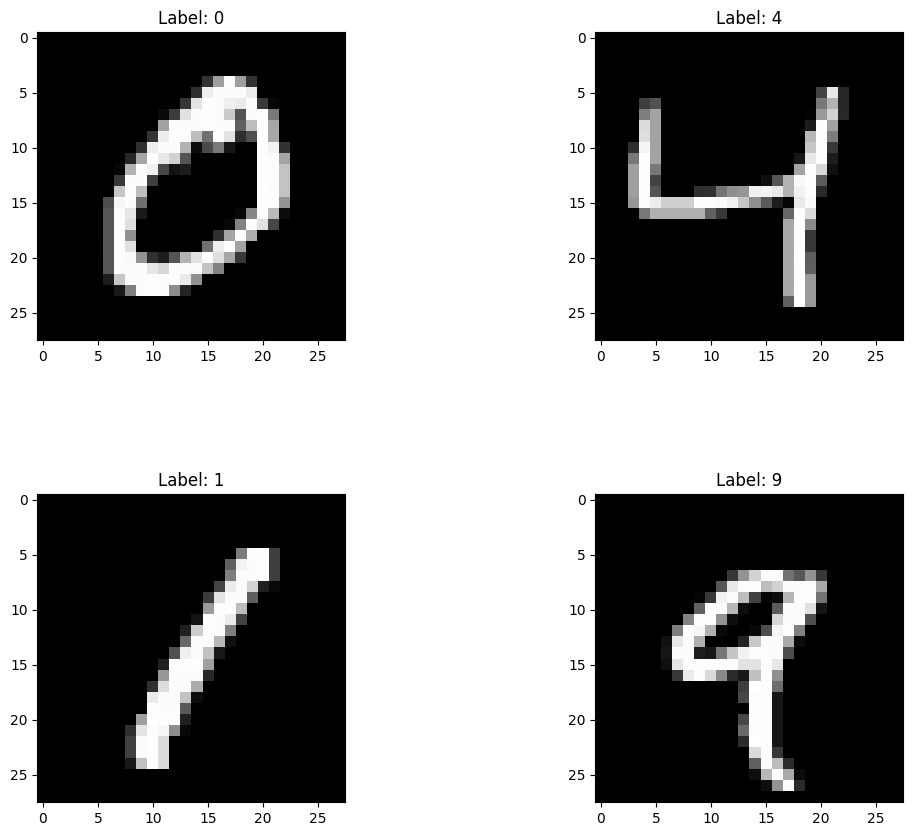

In [8]:
import matplotlib.pyplot as plt

def plot_MNIST_train_examples(my_labels,n_grid = 2):
  figure = plt.figure(figsize=(12, 10))

  #plotting images from the training set
  for i in range(1, n_grid**2 + 1):
    plt.subplot(n_grid, n_grid, i)
    plt.subplots_adjust(hspace =.5, wspace=.5)
    plt.title(f"Label: {my_labels[i]}")

    img = train_images[i].reshape((28,28))
    plt.imshow(img, cmap='gray')

plot_MNIST_train_examples(train_labels)

# Linear Regression (LinR)

We think of linear regression as a [784 by 1] graph.

## Generate random starting paramaters

In [10]:
# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale):
  w_key, b_key = jax.random.split(key)
  return scale * jax.random.normal(w_key, (n, m)), scale * jax.random.normal(b_key, (n,))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key, scale=1e-2):
  keys = jax.random.split(key, len(sizes))
  return [random_layer_params(m, n, k, scale) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

key = jax.random.PRNGKey(int(time.time()))

In [11]:
layer_sizes = [784, 1]
params = init_network_params(layer_sizes, key)

## Create our function and our loss function

In [12]:
layer_sizes = [784, 1]
params = init_network_params(layer_sizes, key)

def LinR(params, image):
  x = image
  # first layer is feedforward
  w, b = params[0]

  ##### FILL IN THE OUTPUT #####
  LinR_Output = (jnp.dot(w, x) + b)[0]
  ##############################
  return LinR_Output

print("Lin Reg on 1st training example:")
print(LinR(params,train_images[0]))

Lin Reg on 1st training example:
12.859804


In [13]:

#### FILL IN#####
#### Make a version of LinR that runs on multple inputs at once ###
#### Hint: Use the magic of JAX!
batched_LinR = jax.vmap(LinR, in_axes=(None, 0)) ###???
################

print("Lin Reg on all training example:")
print(batched_LinR(params,train_images))

Lin Reg on all training example:
[ 12.859804   25.353462  -45.25519   ...  17.748802   -1.8008494
   2.9942842]


In [14]:
def MSE_loss_for_LinR(params,images,target):
  preds = batched_LinR(params, images)

  ### FILL IN THE FORMULA FOR THE MSE
  MSE = jnp.mean( (preds - target)**2 ) ###

  return MSE

print("MSE loss of LinR on training set:")
print(MSE_loss_for_LinR(params,train_images,train_labels))

MSE loss of LinR on training set:
401.44843


# Training loop using gradient descent

Here we will repeatedely update the "params" by using gradient descent

In [15]:
import time

from functools import partial

@partial(jax.jit, static_argnames=['loss_func','step_size'])
def update_params(params, x, y, loss_func, step_size):
  grads = jax.grad(loss_func)(params, x, y)
  return [(w - step_size * dw, b - step_size * db)
          for (w, b), (dw, db) in zip(params, grads)]

def training_loop(loss_func, acc_func=None, num_epochs = 2, step_size = 0.01):
  global params
  saved_results = []
  for epoch in range(1,num_epochs+1):

      print(f"---Epoch #{epoch}---")
      #Update the weights by gradient descent!
      start_time = time.time()
      for x, y in tqdm(training_generator):
          # This loop will create mini-batches of (x,y) paris to train on
          # The batch size is set as part of the training generator
          # Running through all the examples is called an ''epoch''

          ### FILL IN THE FORMULA FOR THE GRADIENT
          ### Hint: Use JAX magic!!
          #turn the labels into one hot vectors
          grads = jax.grad(loss_func)(params, x, y)

          params = update_params(params, x, y, loss_func, step_size)


          #FILL IN THE FORMULA FOR THE W and B UPDATES IN TERMS OF THE PARAMS
          #params = [(w - step_size * dw, b - step_size * db)
          #          for (w, b), (dw, db) in zip(params, grads)]


      #### A bunch of bookeeping here to print and record the infrmation ####
      #Print and record stats of this epoch
      if acc_func != None:
        train_acc = acc_func(params, train_images, train_labels)
        test_acc = acc_func(params, test_images, test_labels)

      train_CE_loss = loss_func(params, train_images, train_labels)
      test_CE_loss = loss_func(params, test_images, test_labels)

      results_dict = {'epoch': epoch,
              'train_loss': np.copy(train_CE_loss).item(),
              'test_loss': np.copy(test_CE_loss).item(),
              }

      if acc_func != None:
        results_dict['train_acc'] = np.copy(train_acc).item()
        results_dict['test_acc'] = np.copy(test_acc).item()

      saved_results += [results_dict]

      epoch_time = time.time() - start_time
      print(f"---Time: {epoch_time:0.2f} sec---")
      if acc_func != None:
        print(f"  Train  acc: {train_acc:0.4f}")
        print(f"  Test   acc: {test_acc:0.4f}")
      print(f"  Train loss: {train_CE_loss:0.4f}")
      print(f"  Test  loss: {test_CE_loss:0.4f}")


  return saved_results

In [17]:
#Train the network!
layer_sizes = [784, 1]
params = init_network_params(layer_sizes, key)
training_loop(MSE_loss_for_LinR,num_epochs=2,step_size = 0.00000001)

---Epoch #1---


100%|██████████| 469/469 [00:10<00:00, 45.29it/s]


---Time: 10.40 sec---
  Train loss: 121.8811
  Test  loss: 117.9377
---Epoch #2---


100%|██████████| 469/469 [00:09<00:00, 47.81it/s]


---Time: 9.84 sec---
  Train loss: 83.3363
  Test  loss: 80.9586


[{'epoch': 1, 'train_loss': 121.88107299804688, 'test_loss': 117.937744140625},
 {'epoch': 2, 'train_loss': 83.3363265991211, 'test_loss': 80.95858764648438}]

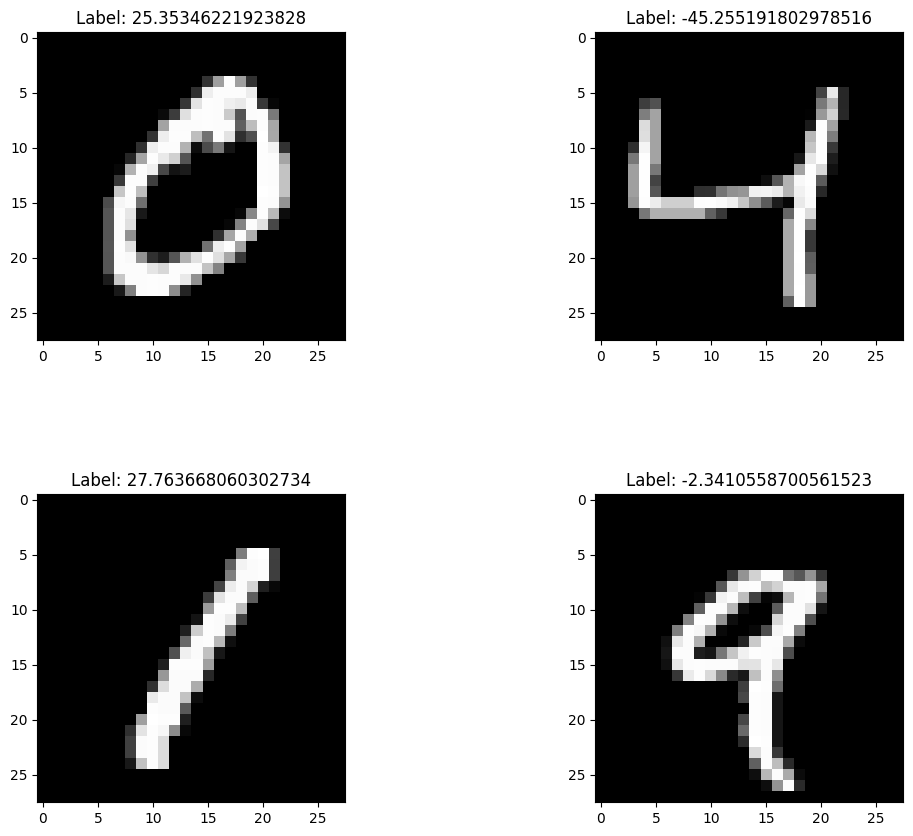

In [16]:
LinR_labels = batched_LinR(params, train_images)
plot_MNIST_train_examples(LinR_labels)

# Non-linear but still regression (NonLinR)

In [18]:
layer_sizes = [784, 1]

def sigmoid(x):
  #Fill in the sigmoid function to "crunch down" (-\infty, \infty) to (0,9)
  return jnp.exp(x)/(1+jnp.exp(x))


def NonLinR(params, image):
  x = image
  # first layer is feedforward
  w, b = params[0]

  #### FILL IN A VERSION
  output_between_0_and_9 = 9*sigmoid( (jnp.dot(w, x) + b) )[0]
  ####

  return output_between_0_and_9 ###


print("NonLinR on a single example:")
print(NonLinR(params,train_images[0]))

batched_NonLinR = jax.vmap(NonLinR, in_axes=(None, 0))
print("NonLinR on a all examples:")
print(batched_NonLinR(params,train_images))

def MSE_loss_for_NonLinR(params,images,target):
  preds = batched_NonLinR(params, images)
  return jnp.mean( (preds - target)**2 )



params = init_network_params(layer_sizes, key, scale = 0.000001)
print("MSE of train set for NonLin R")
print(MSE_loss_for_NonLinR(params,train_images,train_labels))

NonLinR on a single example:
8.287113
NonLinR on a all examples:
[8.2871132e+00 3.5966149e-01 5.3091533e-08 ... 3.2134563e-01 3.1512456e+00
 1.3727202e+00]
MSE of train set for NonLin R
8.346878


In [19]:
layer_sizes = [784, 1]
params = init_network_params(layer_sizes, key, scale = 0.00001)
training_loop(MSE_loss_for_NonLinR,num_epochs=4,step_size = 0.0000001)

---Epoch #1---


100%|██████████| 469/469 [00:12<00:00, 36.95it/s]


---Time: 12.72 sec---
  Train loss: 3.4100
  Test  loss: 3.3944
---Epoch #2---


100%|██████████| 469/469 [00:11<00:00, 39.45it/s]


---Time: 11.91 sec---
  Train loss: 3.3051
  Test  loss: 3.3071
---Epoch #3---


100%|██████████| 469/469 [00:11<00:00, 39.28it/s]


---Time: 11.97 sec---
  Train loss: 3.2555
  Test  loss: 3.2667
---Epoch #4---


100%|██████████| 469/469 [00:13<00:00, 35.99it/s]

---Time: 13.06 sec---
  Train loss: 3.2261
  Test  loss: 3.2433


[{'epoch': 1,
  'train_loss': 3.4099998474121094,
  'test_loss': 3.394380807876587},
 {'epoch': 2,
  'train_loss': 3.3050546646118164,
  'test_loss': 3.307081460952759},
 {'epoch': 3, 'train_loss': 3.255493640899658, 'test_loss': 3.266719341278076},
 {'epoch': 4,
  'train_loss': 3.226147174835205,
  'test_loss': 3.2432522773742676}]

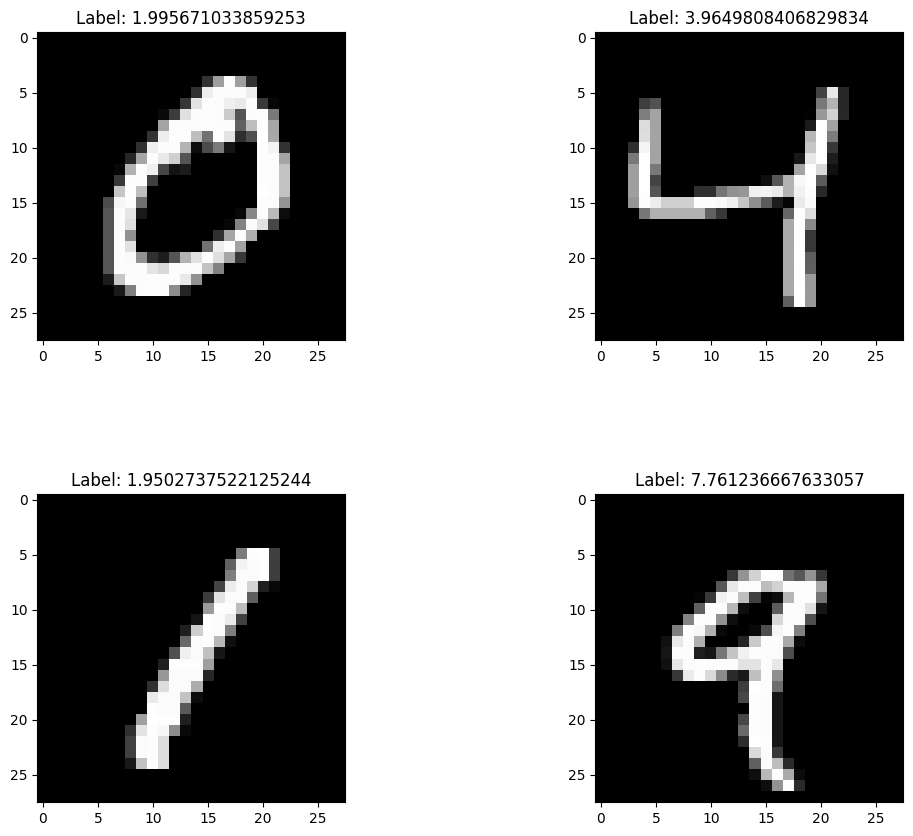

In [20]:
NonLinR_labels = batched_NonLinR(params, train_images)
plot_MNIST_train_examples(NonLinR_labels)

# Logisitic Regression (LogiR)

In [25]:
#Initialize Parameters

#Fill in the SIZE of the output layer for logisitic regression
#Hint: How does logistic regression translate between output
# and the class probabilities when there are more than 2 classes?
output_size = 10
layer_sizes = [784, output_size]
params = init_network_params(layer_sizes, key)

def sigmoid(x):
  return jnp.exp(x)/(1+jnp.exp(x))

def LogiR_logP(params, image):
  x = image
  # first layer is feedforward
  w, b = params[0]

  ##### Fill in the formula for the logits
  logits = jnp.dot(w,x)+b

  #This just makes it so that the logits are not too big
  # (Big logits can cause numerical issues like nan to appear)
  logits_max_zero = logits - jnp.max(logits)

  #### Fill in the formula to get the log(probability) using the logits
  logP = logits_max_zero - jnp.log(jnp.sum(jnp.exp(logits_max_zero)))

  return logP

print("LogiR on one example:")
print(LogiR_logP(params, train_images[0]))

batched_LogiR_logP = jax.vmap(LogiR_logP, in_axes=(None, 0))

print("LogiR on all examples:")
print(batched_LogiR_logP(params, train_images))


def CE_loss_for_LogiR(params,images,target):
  preds = batched_LogiR_logP(params, images)

  #Instead of a target being from 0 to 9, we need to convert this to a vector
  # Fill in how to do it!
  target_as_vector = jax.nn.one_hot(target, 10)

  #FILL IN THE FORMULA FOR CROSS ENTROPY LOSS
  CE_loss = - jnp.mean(preds * target_as_vector)

  return CE_loss

print("CE loss of LogiR on all example:")
print(CE_loss_for_LogiR(params,train_images,train_labels))

LogiR on one example:
[-32.23405    -14.644852   -40.756893   -11.731419    -1.7203101
  -2.3108196  -21.577072    -0.32600582 -34.764748   -24.192358  ]
LogiR on all examples:
[[-3.2234055e+01 -1.4644845e+01 -4.0756897e+01 ... -3.2600477e-01
  -3.4764751e+01 -2.4192358e+01]
 [-5.8179707e+01 -1.0498903e+01 -5.3031670e+01 ... -3.0865669e-03
  -1.2820950e+01 -5.7239197e+01]
 [-1.9454231e+01 -3.7663960e+01 -1.4345931e+01 ... -2.6900379e+01
  -3.6047157e+01 -1.9825144e+00]
 ...
 [-6.4226212e+01 -6.3971989e+01 -9.8594879e+01 ... -3.7111916e+01
  -5.1223362e+01 -8.5640228e+01]
 [-2.5033919e-06 -4.6978439e+01 -7.7941071e+01 ... -1.3675063e+01
  -4.9045689e+01 -2.0279242e+01]
 [-3.1811317e+01 -1.3816819e+01 -5.5391079e+01 ... -3.3441460e+01
  -9.4913614e-01 -2.8461828e+01]]
CE loss of LogiR on all example:
4.332709


In [27]:
# layer_sizes = [784, 10]
# params = init_network_params(layer_sizes, key)

def top1_acc_LogiR(params, images, target_class):
  #Fill in how to get the prediction from the LogiR function
  predicted_class = jnp.argmax(batched_LogiR_logP(params, images), axis=1)
  return jnp.mean(predicted_class == target_class)

training_loop(CE_loss_for_LogiR,top1_acc_LogiR,num_epochs=2,step_size = 0.01)

---Epoch #1---


100%|██████████| 469/469 [00:12<00:00, 39.07it/s]


---Time: 12.13 sec---
  Train  acc: 0.8635
  Test   acc: 0.8536
  Train loss: 1.5961
  Test  loss: 1.8056
---Epoch #2---


100%|██████████| 469/469 [00:12<00:00, 38.98it/s]

---Time: 12.17 sec---
  Train  acc: 0.8663
  Test   acc: 0.8536
  Train loss: 1.7028
  Test  loss: 1.9779


[{'epoch': 1,
  'train_loss': 1.5961456298828125,
  'test_loss': 1.8055574893951416,
  'train_acc': 0.8634999990463257,
  'test_acc': 0.8535999655723572},
 {'epoch': 2,
  'train_loss': 1.7028288841247559,
  'test_loss': 1.9778661727905273,
  'train_acc': 0.8662999868392944,
  'test_acc': 0.8535999655723572}]

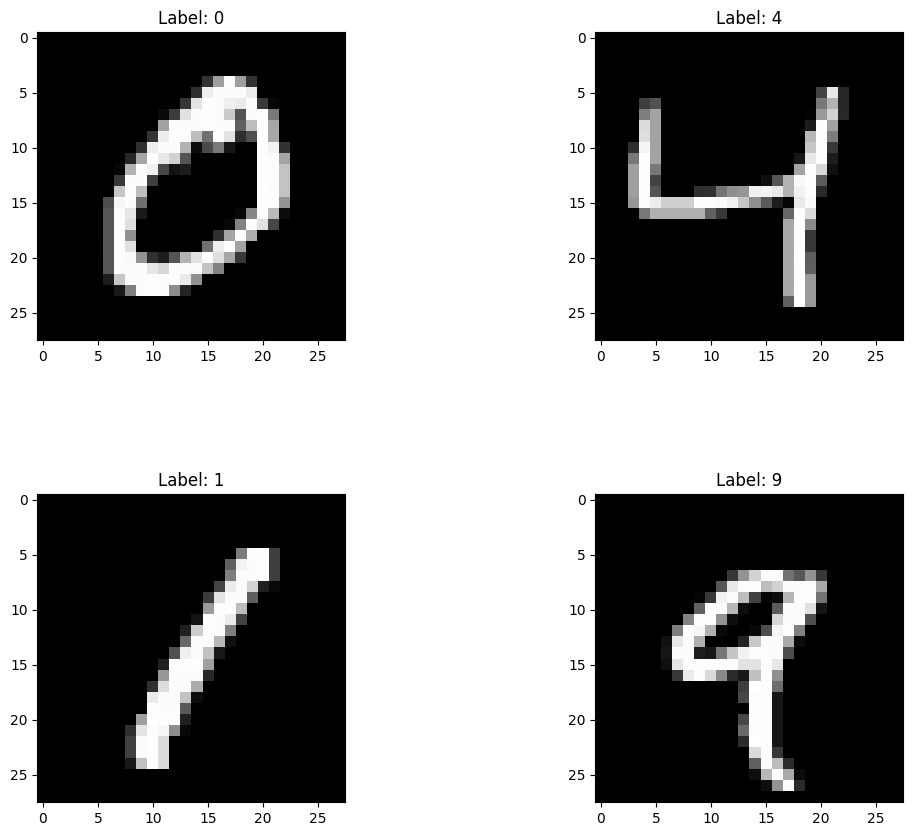

In [28]:
LogiR_labels = batched_LogiR_logP(params, train_images)
plot_MNIST_train_examples(jnp.argmax(LogiR_labels,axis=1))

## Multi-layer perceptron with cross entropy loss (MLP)

In [40]:
#Lets start by making a MLP (aka "a fully connected nerual network")
# with one hidden layer
# FILL IN what layer_sizes should be here
h1 = 500
h2 = 200
layer_sizes = [784, h1, h2, 10]


params = init_network_params(layer_sizes, key)

# rectified linear unit activation function
def relu(x):
  #We will use the rele non-liearity for our nerual network
  return jnp.maximum(x, 0) #


def MLP_logP(params, image):
    # per-example predictions
    # Returns the log probability of each class

    x = image
    # first layer is feedforward
    w, b = params[0]

    #Fill in the formula for the first layer
    x = jnp.dot(w,x)+b
    x_transformed = relu(x) #Apply a non-linear transformation to x

    for w, b in params[1:-1]: #This loops through all the hidden layers
        # Fill in the formula to be applied at all the hidden layers
        x = jnp.dot(w,x) + b
        x_transformed = relu(x)

    final_w, final_b = params[-1]  #This is the last layer
    #Fill in the formula for the logits
    logits = jnp.dot(final_w, x) + final_b
    logits_max_zero = logits - jnp.max(logits)

    #Fill in the formula for the log(prob) using the logits
    logP = logits_max_zero - jnp.log(jnp.sum(jnp.exp(logits_max_zero)))

    return logP

print("MLP logP on a single examples")
print(MLP_logP(params, train_images[0]))

MLP logP on a single examples
[-1.7098026 -2.840459  -2.6106193 -1.7577918 -1.6649449 -2.7008553
 -2.9380264 -2.4206767 -3.678172  -2.393215 ]


In [41]:
# Let's upgrade it to handle batches using `vmap`

# Make a batched version of the `predict` function
batched_MLP_logP = jax.vmap(MLP_logP, in_axes=(None, 0))

# `batched_predict` has the same call signature as `predict`
print("MLP logP on all examples")
batched_preds = batched_MLP_logP(params, train_images)
print(batched_preds)

MLP logP on all examples
[[-1.7098027 -2.8404593 -2.6106195 ... -2.4206772 -3.6781716 -2.3932152]
 [-1.752209  -3.5387316 -1.4384642 ... -3.2113986 -3.0069175 -3.8819904]
 [-1.7725439 -1.8421555 -2.3748777 ... -3.429851  -3.0594983 -2.6708155]
 ...
 [-1.4499248 -2.3455384 -2.2657273 ... -2.8194432 -2.1351361 -2.4262261]
 [-1.3396468 -3.2957962 -2.6438203 ... -3.2160454 -1.4560181 -2.2410383]
 [-1.3069404 -2.7275972 -2.3565335 ... -2.8664246 -2.5910468 -2.130055 ]]


# Loss function

In [42]:
def CE_loss_for_MLP(params, images, target):
  #This is exactly the same as for Logistic Regression!
  preds = batched_MLP_logP(params, images)
  target_one_hot = jax.nn.one_hot(target, 10)
  return -jnp.mean(preds * target_one_hot)

print("CE loss for the the MLP")
print(CE_loss_for_MLP(params, train_images, train_labels))


CE loss for the the MLP
0.25368938


In [45]:
# layer_sizes = [784, 784, 10] # One hidden layer of 784 Neurons
# params = init_network_params(layer_sizes, key)


def top1_acc_MLP(params, images, target_class):
  predicted_class = jnp.argmax(batched_MLP_logP(params, images), axis=1)
  return jnp.mean(predicted_class == target_class)

training_loop(CE_loss_for_MLP, top1_acc_MLP, num_epochs = 10)

---Epoch #1---


100%|██████████| 469/469 [00:21<00:00, 21.43it/s]


---Time: 23.41 sec---
  Train  acc: 0.8840
  Test   acc: 0.8798
  Train loss: 0.0414
  Test  loss: 0.0444
---Epoch #2---


100%|██████████| 469/469 [00:21<00:00, 22.29it/s]


---Time: 22.52 sec---
  Train  acc: 0.8868
  Test   acc: 0.8825
  Train loss: 0.0400
  Test  loss: 0.0431
---Epoch #3---


100%|██████████| 469/469 [00:19<00:00, 23.77it/s]


---Time: 21.18 sec---
  Train  acc: 0.8891
  Test   acc: 0.8840
  Train loss: 0.0389
  Test  loss: 0.0420
---Epoch #4---


100%|██████████| 469/469 [00:21<00:00, 22.18it/s]


---Time: 22.67 sec---
  Train  acc: 0.8905
  Test   acc: 0.8867
  Train loss: 0.0380
  Test  loss: 0.0412
---Epoch #5---


100%|██████████| 469/469 [00:20<00:00, 23.42it/s]


---Time: 22.12 sec---
  Train  acc: 0.8921
  Test   acc: 0.8886
  Train loss: 0.0373
  Test  loss: 0.0405
---Epoch #6---


100%|██████████| 469/469 [00:20<00:00, 23.21it/s]


---Time: 21.75 sec---
  Train  acc: 0.8933
  Test   acc: 0.8919
  Train loss: 0.0367
  Test  loss: 0.0399
---Epoch #7---


100%|██████████| 469/469 [00:21<00:00, 22.03it/s]


---Time: 22.86 sec---
  Train  acc: 0.8948
  Test   acc: 0.8924
  Train loss: 0.0361
  Test  loss: 0.0395
---Epoch #8---


100%|██████████| 469/469 [00:19<00:00, 23.58it/s]


---Time: 21.40 sec---
  Train  acc: 0.8965
  Test   acc: 0.8940
  Train loss: 0.0356
  Test  loss: 0.0390
---Epoch #9---


100%|██████████| 469/469 [00:21<00:00, 22.01it/s]


---Time: 22.89 sec---
  Train  acc: 0.8969
  Test   acc: 0.8949
  Train loss: 0.0352
  Test  loss: 0.0387
---Epoch #10---


100%|██████████| 469/469 [00:21<00:00, 21.75it/s]


---Time: 23.20 sec---
  Train  acc: 0.8979
  Test   acc: 0.8960
  Train loss: 0.0348
  Test  loss: 0.0383


[{'epoch': 1,
  'train_loss': 0.0414392426609993,
  'test_loss': 0.044432345777750015,
  'train_acc': 0.8840000033378601,
  'test_acc': 0.8797999620437622},
 {'epoch': 2,
  'train_loss': 0.040022771805524826,
  'test_loss': 0.0430670790374279,
  'train_acc': 0.8867999911308289,
  'test_acc': 0.8824999928474426},
 {'epoch': 3,
  'train_loss': 0.038925446569919586,
  'test_loss': 0.04202347993850708,
  'train_acc': 0.8890999555587769,
  'test_acc': 0.8840000033378601},
 {'epoch': 4,
  'train_loss': 0.03803578391671181,
  'test_loss': 0.041191257536411285,
  'train_acc': 0.8904999494552612,
  'test_acc': 0.8866999745368958},
 {'epoch': 5,
  'train_loss': 0.03729213774204254,
  'test_loss': 0.04050878807902336,
  'train_acc': 0.8920999765396118,
  'test_acc': 0.8885999917984009},
 {'epoch': 6,
  'train_loss': 0.036656733602285385,
  'test_loss': 0.039937470108270645,
  'train_acc': 0.8932999968528748,
  'test_acc': 0.8919000029563904},
 {'epoch': 7,
  'train_loss': 0.036104802042245865,
  

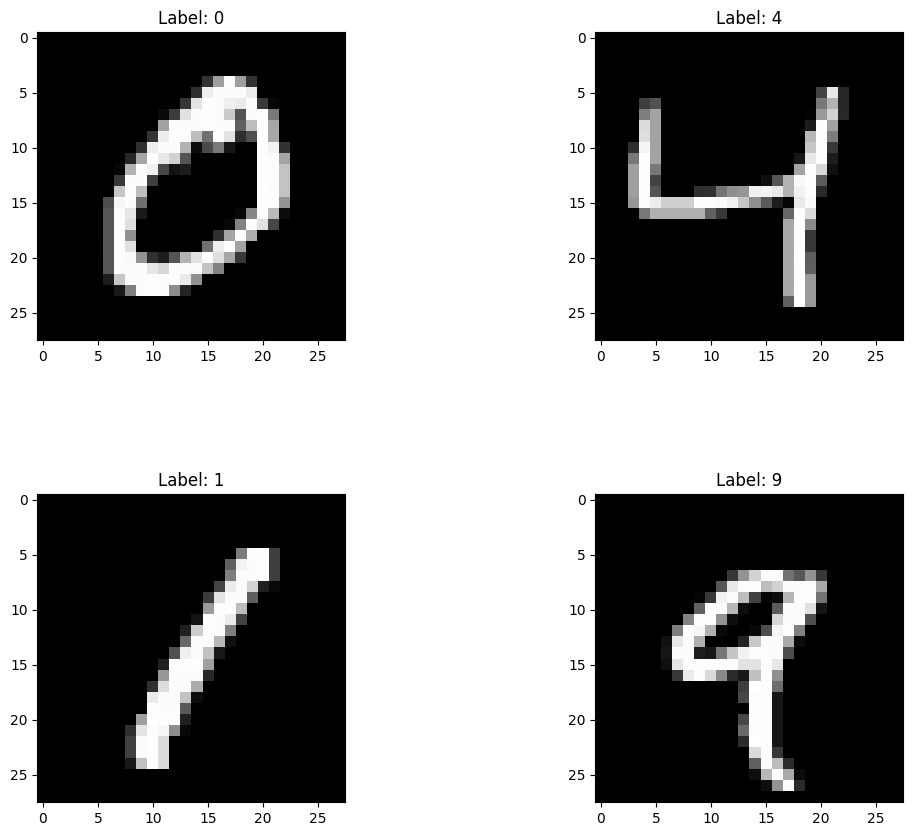

In [49]:
MLP_preds = batched_MLP_logP(params, train_images)
MLP_labels = jnp.argmax(MLP_preds,axis=1)
plot_MNIST_train_examples( MLP_labels)

In [50]:
def plot_incorrect_MNIST_train_examples(my_labels,n_grid = 2):
  figure = plt.figure(figsize=(12, 12))

  #plotting images from the training set
  image_ix = 0
  for i in range(1, n_grid**2 + 1):
    image_ix += 1
    plt.subplot(n_grid, n_grid, i)
    plt.subplots_adjust(hspace =.5, wspace=.5)
    while train_labels[image_ix] == my_labels[image_ix]: #loop through to find incorrectly labeled examples
      image_ix += 1
    plt.title(f"My Label: {my_labels[image_ix]}, Actual: {train_labels[image_ix]}")
    img = train_images[image_ix].reshape((28,28))
    plt.imshow(img, cmap='gray')

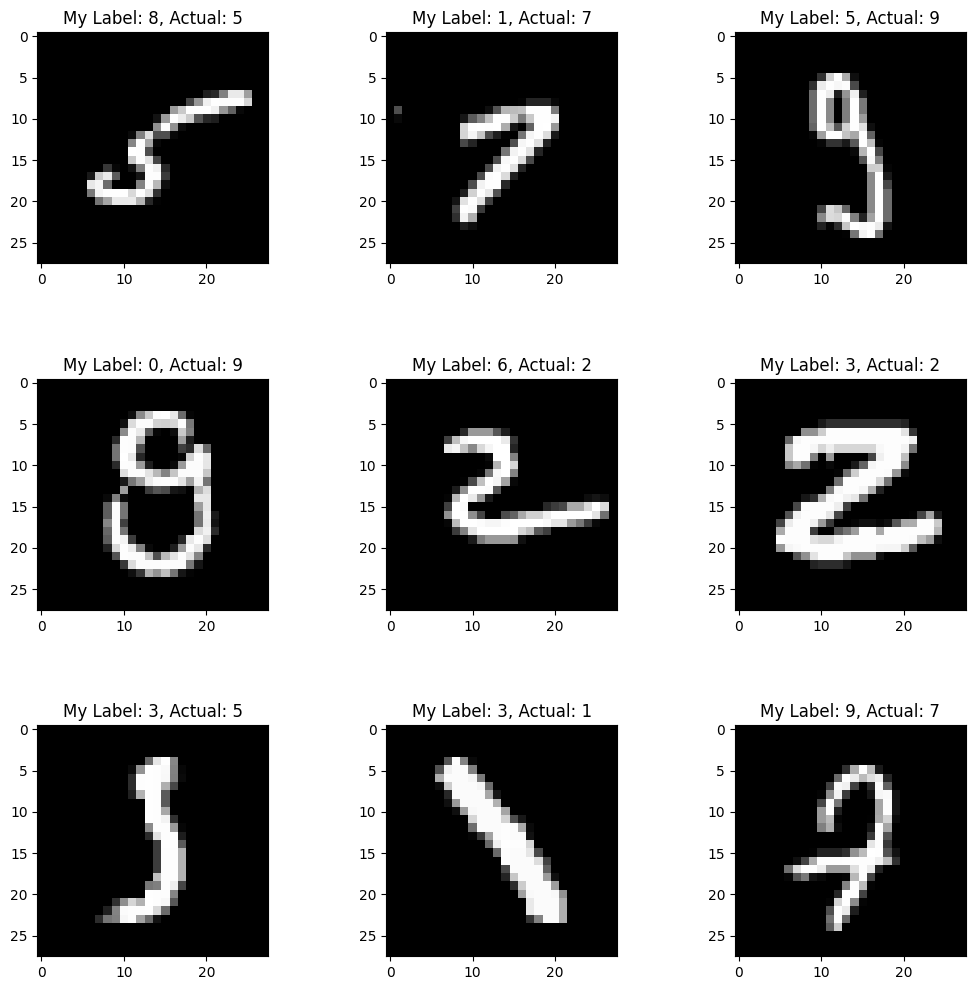

In [51]:
MLP_preds = batched_MLP_logP(params, train_images)
MLP_labels = jnp.argmax(MLP_preds,axis=1)
plot_incorrect_MNIST_train_examples( MLP_labels,n_grid = 3)